# Probabilistic Numerical Methods

Probabilistic numerical methods solve numerical problems from linear algebra, optimization, quadrature and differential equations using _probabibilistic inference_. This approach captures uncertainty arising from finite computational resources and from stochastic input. 

In order to illustrate what PN methods are and how they work consider the following deliberately simple numerical problem.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
plt.style.use('../probnum.mplstyle')

## A Simple Numerical Problem

Consider the following one-dimensional optimization problem $$\underset{x \in \mathbb{R}}{\operatorname{min}} f(x) = \underset{x \in \mathbb{R}}{\operatorname{min}} \frac{1}{2} ax^2 + bx + c,$$ where $f$ is a quadratic function and we assume $a > 0$. Since $f$ is a strictly convex function there exists a unique minimum given by $$f'(x_*) = 0 \iff x_*=-\frac{b}{a}.$$

In [2]:
import numpy as np
import probnum as pn

# Quadratic objective function
a = 2
b = -1.0
c = 3.0
x_opt = - b / a

def f(x):
    return 0.5 * a * x ** 2 + b * x + c

def df(x):
    return a * x + b

Now suppose we are not given access to the coefficients, but only the ability to evaluate $f$ and its derivative $f'$ at arbitrary points. We can then evaluate the derivative twice at $x=0$ and $x=1$ to find the parameters $a$ and $b$ or more generally use a numerical method such as gradient descent to solve the problem.

## Introducing Noise

However, what happens if we go one step further and function evaluations are corrupted by additive noise? This is often the case in practice where $f$ might describe a complex physical system or depend on data. Can we still design an efficient algorithm which finds the minimum?

Suppose we only have access to noisy evaluations $$\hat{y} = \hat{f}(x) = \frac{1}{2}(a + \varepsilon_a)x^2 + (b+\varepsilon_b)x + (c + \varepsilon_c)$$  of the objective function $f$ at $x$, where $\varepsilon = (\varepsilon_a, \varepsilon_b, \varepsilon_c) \sim \mathcal{N}(0, \Sigma)$ and $\Sigma \in \mathbb{R}^{3 \times 3}$ symmetric positive definite.

> *Remark*: The $n$-dimensional analogue of this case arises for example in supervised (deep) learning. In large-scale empirical risk minimization the available training data often does not fit into (local) memory, so during optimization only batches of data are considered inducing noise on the objective function and its gradient. Here $\hat{f}$ is analogous to the empirical risk on the current batch.

In [3]:
from probnum import random_variables as rvs

# Noisy objective function
Sigma = np.diag([0.02, 0.1, 0.01])
eps = rvs.Normal(np.zeros(3), Sigma)

def f_hat(x, noise=eps.sample(1)):
    return 0.5 * (a + noise[0]) * x ** 2 + (b + noise[1]) * x + c + noise[2]

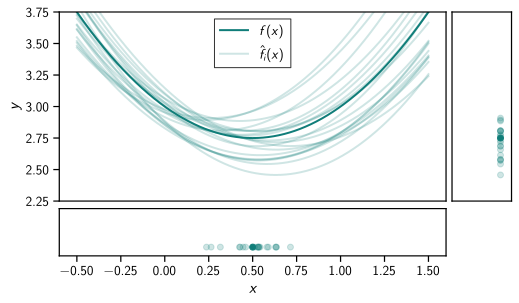

In [16]:
# Random seed
np.random.seed(42)

# Plot objective and noisy evaluations
n_samples = 20
xx = np.linspace(x_opt - 1, x_opt + 1, 1000)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row", figsize=[7.5, 4.5], 
                         gridspec_kw={"height_ratios": [4, 1], "width_ratios": [6.5, 1]})
ylim00 = [2.25, 3.75]
ylim10 = [-0.25, 1.1]

# Function, optimal function value and optimum
axes[0, 0].plot(xx, f(xx), label="$f(x)$")
axes[1, 0].scatter(x_opt, 0, label="$\operatorname{argmin} f(x)$")
axes[0, 1].scatter(ylim10[1] + ylim10[0], f(x_opt), label="$\min f(x)$")
for i in range(n_samples):
    noise = eps.sample()
    x_opt_noise = -(b + noise[1]) / (a + noise[0])
    if i == 0:
        sample_label = "$\\hat{f}_i(x)$"
    else:
        sample_label = None
    axes[0, 0].plot(xx, f_hat(xx, noise), color="C0", alpha=0.2, label=sample_label)
    axes[1, 0].scatter(x_opt_noise, 0, color="C0", alpha=0.2)
    axes[0, 1].scatter(ylim10[1] + ylim10[0], f_hat(x_opt_noise, noise), color="C0", alpha=0.2)

axes[0, 0].get_xaxis().set_visible(False)
axes[1, 0].get_yaxis().set_visible(False)
axes[0, 1].get_yaxis().set_visible(False)
axes[0, 1].get_xaxis().set_visible(False)
axes[1, 1].axis("off")

axes[0, 0].set_ylim(ylim00)
axes[1, 0].set_ylim(ylim10)
axes[0, 1].set_xlim(ylim10)
axes[0, 0].set_ylabel("$y$")
axes[1, 0].set_xlabel("$x$")
axes[0, 0].legend(loc="upper center")

plt.tight_layout(h_pad=0, w_pad=0)
plt.show()

This makes the optimization problem considerably more difficult depending on the degree of noise. Can we still come up with a computationally efficient and accurate algorithm that makes use of the information we have about the problem? We will do so by designing a custom _probabilistic numerical method_. 

## Components of a PN Method

A naive strategy to solve the problem given only the ability to evaluate the noisy function $\hat{f}$ could be to simply choose random points on the real axis and return the point of lowest observed function value. However, clearly this is suboptimal since it completely ignores information we have and collect about the problem. For example we know we are trying to solve a latent quadratic problem. 

Suppose we have some idea of where the minimum of the function $f$ lies or an idea about what coefficients of the quadratic function are likely. This could come from experience, a physical application from which the problem arises or related optimization problems we have solved in the past. 

### Prior

In [5]:
# Prior on parameters: a, b, c
f_params = rvs.Normal(np.array([1.5, -2, 4]), 0.05 * np.eye(3))
x0 = 1.0

# Induced prior on optimal function value
def f_opt0(x):
    x = np.asarray(x).reshape(-1, 1)
    return np.hstack((x ** 2, x, np.ones_like(x))) @ f_params

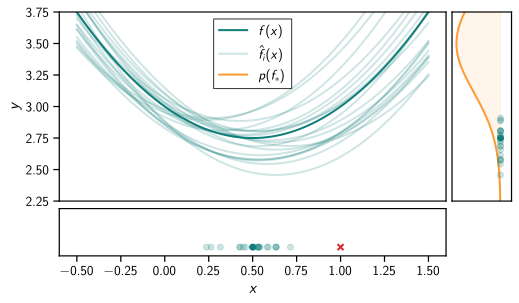

In [17]:
# Random seed
np.random.seed(42)

# Plot objective and noisy evaluations
yy = np.linspace(ylim00[0], ylim00[1], 1000)
#f0_pdf = f_opt0(x0).pdf(yy)
#f0_pdf_max = np.max(f0_pdf)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row", figsize=[7.5, 4.5], 
                         gridspec_kw={"height_ratios": [4, 1], "width_ratios": [6.5, 1]})

# Function, optimal function value and optimum
axes[0, 0].plot(xx, f(xx), label="$f(x)$")
axes[1, 0].scatter(x_opt, 0)
axes[1, 0].scatter(x0, 0, color="C3", marker="x", label="$x_0$")
axes[0, 1].scatter(ylim10[1] + ylim10[0], f(x_opt))
axes[0, 1].fill_betweenx(y=yy, 
                         x1=ylim10[1] + ylim10[0] - f0_pdf / f0_pdf_max, 
                         x2=ylim10[1] + ylim10[0],
                         color="C1", alpha=0.1, zorder=-1)
axes[0, 1].plot(ylim10[1] + ylim10[0] - f0_pdf / f0_pdf_max, yy, 
                color="C1", label="$p(f_*)$", zorder=-1)
for i in range(n_samples):
    noise = eps.sample()
    x_opt_noise = -(b + noise[1]) / (a + noise[0])
    if i == 0:
        sample_label = "$\\hat{f}_i(x)$"
    else:
        sample_label = None
    axes[0, 0].plot(xx, f_hat(xx, noise), color="C0", alpha=0.2, label=sample_label)
    axes[1, 0].scatter(x_opt_noise, 0, color="C0", alpha=0.2)
    axes[0, 1].scatter(ylim10[1] + ylim10[0], f_hat(x_opt_noise, noise), color="C0", alpha=0.2)

axes[0, 0].get_xaxis().set_visible(False)
axes[1, 0].get_yaxis().set_visible(False)
axes[0, 1].get_yaxis().set_visible(False)
axes[0, 1].get_xaxis().set_visible(False)
axes[1, 1].axis("off")

axes[0, 0].set_ylim(ylim00)
axes[1, 0].set_ylim(ylim10)
axes[0, 1].set_xlim(ylim10)
axes[0, 0].set_ylabel("$y$")
axes[1, 0].set_xlabel("$x$")
handles, labels = [(a + b) for a, b in zip(axes[0, 0].get_legend_handles_labels(), 
                                           axes[0, 1].get_legend_handles_labels())]
axes[0, 0].legend(handles, labels, loc="upper center")

plt.tight_layout(h_pad=0, w_pad=0)
plt.show()

We would like to use this prior information to solve the optimization problem in question. In order to do so we need to collect information about the problem, which we do by evaluating $\hat{f}$ at chosen points $x$. 

### Policy

In order to collect information about the problem we need to decide where to evaluate the (noisy) objective function $\hat{f}$. This is done via a _policy_ $\pi$. In principle this can be any function which maps to the domain of $\hat{f}$, however it is sensible to use the model of the problem our algorithm is building resulting in a model-based policy.

In [7]:
def random_walk_policy(x_opt0, region=(-1.5, 1.5)):
    """A uniform sampling policy."""
    return np.random.uniform(low=region[0], high=region[1])

def greedy_policy(x_opt0):
    """Greedy model-based policy."""
    return x_opt0.mean
                  
def sampling_policy(x_opt0):
    """Sampling model-based policy."""
    return x_opt0.sample(1)[0]   

def entropy_search_policy(x_opt0):
    """Entropy search."""
    return 0

In [8]:
print(f"Suggested evaluation points by a\n \t random walk policy {random_walk_policy(x_opt0):.2f},\n \t greedy policy {greedy_policy(x_opt0):.2f}, \n \t sampling model-based policy {sampling_policy(x_opt0):.2f}, and \n \t entropy search {entropy_search_policy(x_opt0):.2f}.")

NameError: name 'x_opt0' is not defined

### Action and Observation

We now use our policy to collect observations about the problem by evaluating the objective function at the suggested evaluation point(s).

In [ ]:
def observe(f, x_eval):
    """Observe the function value at x."""
    return f(x_eval)

### Inference Step

Given the noise model we can compute the distribution of the random variable $f(x)$ for a given evaluation point $x$ using the properties of Gaussians $$\hat{y} \sim \mathcal{N}\bigg(f(x), \begin{pmatrix}x^2 & x & 1 \end{pmatrix}\Sigma \begin{pmatrix}x^2 \\ x\\1 \end{pmatrix}\bigg).$$

By Gaussian inference rules this results in the posterior
$$
p(x \mid y) = \mathcal{N}\bigg( \bigg)
$$

### Stopping Criteria

In [ ]:
def stopping_criterion(f, current_iter, maxiter=100, tol=10**-6):
    """Convergence criteria."""
    return current_iter >= maxiter or f.cov < tol

## Putting It All Together

In [ ]:
def probsolve_qp(f, f_opt0, policy=sampling_policy, stopping_criterion=stopping_criterion):
    """
    Probabilistic Quadratic Optimization.
    
    PN method solving unconstrained one-dimensional (noisy) quadratic 
    optimization problems only needing access to function evaluations.
    """
    iteration = 0
    # Iterate until stopping criterion
    while not stopping_criterion(x_opt0, iteration):
        
        # Policy
        x_eval = policy(x_opt0)
        print(f"evaluation point: {x_eval:.2f}")
        
        # Observation
        y = observe(f, x_eval)
        print(f"function value: {y:.2f}")
        
        # Inference
        mean_updated = x_opt0.mean
        cov_updated = x_opt0.cov / 1.5
        f_opt0 = rvs.Normal(mean_updated, cov_updated)
        
        iteration += 1
        
    return x_opt0

In [ ]:
x_sol = probsolve_qp(f_hat, x_opt0)

## Some Advantages of a PN Method

- Incorporation of prior knowledge

### Hyperparameter Optimization

- set degrees of freedom / parameters of numerical methods automatically / in a principled way using the Bayesian formalism
- Learn the noise level from the data via model evidence

### Solution of Related Problems

## Outlook


### Connections to 
- Inference = Gaussian process regression
- Bayesian Optimization
- Probabilistic Linear Solver <a href="../automod/probnum.linalg.problinsolve.html#probnum.linalg.problinsolve">`probnum.linalg.problinsolve`</a>
    - Krylov space policy coincides with greedy policy in 1D case

### Implement a PN Method in ProbNum
- Development Tutorial

If you want to try out these tutorials for yourself, you can download the notebooks from the
[GitHub repository](https://github.com/probabilistic-numerics/probnum/tree/master/docs/source/tutorials).

## Notes

### Variant 1: $p(x)$

- termination criterion
- output random variable $x$
- requires knowledge of $a,b$ not just $f(x)$

### Variant 2: $p(f)$

- Inference easy with prior over $a,b,c$
- Noise inference possible via model evidence
- policy
    - random walk
    - sampling: $(a,b,c) \sim posterior$ results in $x_i = -\frac{b}{a}$
    - sampling based but with Krylov dynamics, i.e. $x_i = -\frac{ax_{i-1} - b}{a}$
    - (approximation to) [expected improvement](https://arxiv.org/pdf/1807.02811.pdf) ($\approx$ postvar / mean => high variance: exploration, small mean: exploitation (close to minimum)
- stopping criterion
    - posterior contraction of $f(x_i)$
- posterior on $x$ only has [pdf](https://rstudio-pubs-static.s3.amazonaws.com/287838_7c982110ffe44d1eb5184739c5724926.html) and sample function
- Gaussian approximation for $x$ exists (but is potentially arbitrarily bad)
- Bayesian Optimization analogy